In [ ]:
!pip install -q "torchaudio<0.12.0"

In [ ]:
!pip install -q transformers #==4.11.3

In [ ]:
!pip install -q datasets

In [ ]:
!pip install -q huggingface_hub

In [ ]:
!pip install -q phonemizer

In [ ]:
!pip install -q russtress

In [ ]:
!pip install -q py-espeak-ng
!sudo apt-get install python-espeak
!sudo apt-get update && sudo apt-get install espeak

In [ ]:
!pip install -q npy-append-array

In [ ]:
import json
#import torch
import re
import gc
#import torchaudio
import random
#import phonemizer
import numpy as np
import pandas as pd
#import soundfile as sf
import seaborn as sns
import matplotlib.pyplot as plt
#from npy_append_array import NpyAppendArray
#from russtress import Accent
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from huggingface_hub import hf_hub_download
#from datasets import load_dataset, Audio
#from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, Wav2Vec2Processor, Wav2Vec2Tokenizer, Wav2Vec2Config

#### Model and data

In [ ]:
config = Wav2Vec2Config.from_pretrained("facebook/wav2vec2-xlsr-53-espeak-cv-ft", output_hidden_states=True)
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-xlsr-53-espeak-cv-ft", config=config)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-xlsr-53-espeak-cv-ft")

In [ ]:
MODEL_ID = "jonatasgrosman/wav2vec2-large-xlsr-53-russian"
processor_full = Wav2Vec2Processor.from_pretrained(MODEL_ID)
model_full = Wav2Vec2ForCTC.from_pretrained(MODEL_ID)

In [ ]:
LANG_ID = "ru"
SAMPLES = 1500
ds = load_dataset("common_voice", LANG_ID, split=f"train[:{SAMPLES}]")

In [ ]:
_file = hf_hub_download(repo_id="facebook/wav2vec2-xlsr-53-espeak-cv-ft", filename="vocab.json")
with open(_file, 'r') as f:
  vocab = json.loads(f.read())
convenient_vocab = {}
for k, v in vocab.items():
  convenient_vocab[v] = k

In [ ]:
vowels = set(['ɪ', 'uː', 'ʌ', 'iː', 'ɛ', 'ɑː', 'ə', 'i', 'oʊ', 'æ', 'ɐ', 'aʊ', 'ʊ', 'aɪ', 'eɪ', 'oː', 'a', 'oɪ', 'ɔ', 'ɚ', 'eː', 'ᵻ', 'o', 'aː', 'e', 'ɑ', 'u'])
voiced = set(['b', 'd', 'dʒ', 'j', 'l', 'm', 'n', 'v', 'w', 'z', 'ɡ', 'ɲ', 'əl', 'ɹ', 'ɾ', 'ʒ', 'ŋ', 'ð', 'r'])
voiceless = set(['f', 'h', 'k', 'p', 's', 't', 'ts', 'tʃ', 'ʃ', 'θ'])
consonants = voiced.union(voiceless)
soft = set(['dʲ', 'j', 'mʲ', 'nʲ', 'rʲ', 'sʲ', 'tʲ', 'ɭʲ', 'ɟ', 'ç', 'tʃʲ', 'tʃ', 'ɲ', 'ʎ'])
hard = consonants - soft

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Probing/Data/'

#### Functions

In [ ]:
# audio preprocessing
def speech_file_to_array_fn(batch):
  speech_array, sampling_rate = torchaudio.load(batch["path"])
  resampler = torchaudio.transforms.Resample(sampling_rate, 16_000)
  new_audio = resampler(speech_array).squeeze().numpy()
  batch["speech"] = new_audio
  batch["sentence"] = batch["sentence"].upper()
  return batch

In [ ]:
# get accent on word to get words which end with stress
# to analyze how model understands russian vowels
def get_accent(word):
  accent = Accent()
  accented_text = accent.put_stress(word)
  return accented_text

In [ ]:
# create dataframe with words which end with stress
# and their phinetic transcription
def create_dataframe(predicted_words, predicted_sounds):
  # global words_df
  last_i = 0
  for j, preds in enumerate(predicted_words):
    for i, id in enumerate(preds):
      if id == 4:
        soundword_ids = predicted_sounds[j][last_i:i]
        word_ids = predicted_words[j][last_i:i]
        word = processor_full.batch_decode([i for i in word_ids if i != 0])
        soundword = processor.batch_decode([i for i in soundword_ids if i != 0])
        word = ''.join(word)
        soundword = "".join(soundword)
        last_i = i
        if word.isalpha():
          word_accent = get_accent(word)
          if word_accent.endswith("'"):
            with open(path + 'words_df.csv', 'a') as f:
              f.write(f'{word},{soundword}\n')
          #words_df = words_df.append({'word': ''.join(word), 'soundword': ''.join(soundword)}, ignore_index=True)

In [ ]:
# create dictionary for vectors for each sound on each layer
def sound_vectors(n, layer, predicted_ids):
  numpy_logits = layer[0].detach().numpy()
  for i in range(len(predicted_ids[0])):
    if predicted_ids[0][i] not in [1, 2, 3, 0]:
      all_sound_vectors[n][convenient_vocab[predicted_ids[0][i]]].append(numpy_logits[i])

#### Data

In [ ]:
all_sound_vectors = [defaultdict(list) for i in range(26)]
layers = []

In [ ]:
for i in tqdm(range(150)):
  small_ds = ds.select(range(i, i+1))
  small_ds = small_ds.map(speech_file_to_array_fn)

  input_sounds = processor(small_ds["speech"], sampling_rate=16_000, return_tensors="pt", padding=True).input_values
  input_words = processor_full(small_ds["speech"], sampling_rate=16_000, return_tensors="pt", padding=True).input_values
  
  outputs = model(input_sounds)
  logits = outputs.logits
  logits_words = model_full(input_words).logits

  predicted_words = torch.argmax(logits_words, dim=-1)
  predicted_sounds = torch.argmax(logits, dim=-1).detach().numpy()
  create_dataframe(predicted_words, predicted_sounds)

  del input_words
  del logits_words
  del predicted_words

  hidden_states = outputs.hidden_states
  layers.extend(hidden_states)
  layers.append(logits)

  for n, layer in enumerate(layers):
    sound_vectors(n, layer, predicted_sounds)

  for j in range(26):
    filename = f'{path}/{j}_layer.npy'
    arr = np.array(list(all_sound_vectors[j].items()))
    if i == 0:
      np.save(filename, arr)
    else:
    my_arr = np.load(filename, allow_pickle=True)
    np.save(filename, np.concatenate((my_arr, arr)))

  all_sound_vectors = [defaultdict(list) for i in range(26)]
  layers = []

  del input_sounds
  del outputs
  del logits
  del hidden_states
  del predicted_sounds
  
  gc.collect()

##### Fucnctions to divide data for experiments

In [ ]:
def get_list_of_vectors(vectors):
  new_list = []
  for v in vectors:
    new_list.extend(v)
  return new_list

def get_vectors(df, testname):
  sounds = []
  rand_sounds = []
  vectors = []
  only_cons = False

  if testname=='vowel/consonant':
    need_division = vowel_or_not
    rand_division = rand_vowel_or_not
  elif testname=='voiced/voiceless':
    need_division = voiced_or_not
    rand_division = rand_voiced_or_not
    only_cons = True
  elif testname=='soft/hard':
    need_division = soft_or_not
    rand_division = rand_soft_or_not
    only_cons = True
  
  if only_cons:
    for sound in soft.union(hard):
      my_vectors = df[df['sound']==sound]['vector'].tolist()
      my_vectors = get_list_of_vectors(my_vectors)
      vectors.extend(my_vectors)
      sounds.extend([need_division[sound]]*len(my_vectors))
      rand_sounds.extend([rand_division[sound]]*len(my_vectors))
  else:
    for sound in all_sounds:
      my_vectors = df[df['sound']==sound]['vector'].tolist()
      my_vectors = get_list_of_vectors(my_vectors)
      vectors.extend(my_vectors)
      sounds.extend([need_division[sound]]*len(my_vectors))
      rand_sounds.extend([rand_division[sound]]*len(my_vectors))
  
  return sounds, rand_sounds, vectors

def get_scores(sounds, vectors):
  logreg = LogisticRegression(max_iter=1000)
  X_train , X_test , Y_train , Y_test = train_test_split(vectors,sounds,train_size = .8)
  under_sampler = RandomUnderSampler(random_state=42)
  X_res, y_res = under_sampler.fit_resample(X_train, Y_train)
  logreg.fit(X_res, y_res)
  score = logreg.score(X_test, Y_test)
  
  return score

#### Experiments

In [ ]:
vowels = set(['a', 'oː', 'ə', 'ʌ', 'e', 'aː', 'y', 'ɛ', 'o', 'ɪ',
              'aɪ', 'i', 'u', 'eː', 'ɑ', 'iː', 'uː', 'ɔ', 'ʊ', 
              'aʊ', 'ɐ', 'eɪ', 'ɑː', 'oɪ', 'ɨ', 'ɯ', 'ø'])
voiced = set(['b', 'n', 'j', 'r', 'm', 'd', 'ɾ', 'dʲ', 'z',
              'ʒ', 'ɲ', 'l', 'ɡ', 'ɭʲ', 'nʲ', 'ɭ', 'rʲ', 'ʎ',
              'dʒ', 'w', 'mʲ', 'ŋ', 'ɹ', 'ð', 'ɟ'])
voiceless = set(['v', 's', 'ʃ', 't', 'p', 'f', 'tʃ', 'tʲ', 'k',
                 'sʲ', 'x', 'ts', 'ç', 'h', 'ɕ', 'tʃʲ', 'vʲ'])
consonants = voiced.union(voiceless)
soft = set(['dʲ', 'j', 'mʲ', 'nʲ', 'rʲ', 'sʲ', 'tʲ', 'ɭʲ', 'ɟ', 'ç', 'ɕ', 'tʃʲ', 'tʃ', 'ɲ', 'ʎ', 'vʲ'])
hard = consonants - soft
all_sounds = vowels.union(consonants)

In [ ]:
vowel_or_not = {}
voiced_or_not = {}
soft_or_not = {}

for sound in all_sounds:
  if sound in vowels:
    vowel_or_not[sound] = 'vowel'
  else:
    vowel_or_not[sound] = 'consonant'
  
  if sound in voiced:
    voiced_or_not[sound] = 'voiced'
  elif sound in voiceless:
    voiced_or_not[sound] = 'voiceless'

  if sound in soft:
    soft_or_not[sound] = 'soft'
  elif sound in hard:
    soft_or_not[sound] = 'hard'

rand_vowel_or_not = {}
rand_voiced_or_not = {}
rand_soft_or_not = {}

vow_con = ['vowel', 'consonant']
voiced_less = ['voiced', 'voiceless']
soft_hard = ['soft', 'hard']

for sound in all_sounds:
  rand_vowel_or_not[sound] = random.choice(vow_con)
  if sound not in vowels:
    rand_voiced_or_not[sound] = random.choice(voiced_less)
    rand_soft_or_not[sound] = random.choice(soft_hard)

In [ ]:
scores = defaultdict(list)
rand_scores = defaultdict(list)
full_rand_scores = defaultdict(list)

In [ ]:
# get accuracy score for each layer
for testname in ['soft/hard', 'vowel/consonant', 'voiced/voiceless']:
  for i in tqdm(range(26)):
    df = pd.DataFrame(np.load(f'{path}{i}_layer.npy', allow_pickle=True))
    df = df.rename(columns={0: 'sound', 1: 'vector'})

    sounds, rand_sounds, vectors = get_vectors(df, testname)
    full_rand = [el for el in sounds]
    random.shuffle(full_rand)

    score = get_scores(sounds, vectors)
    rand_score = get_scores(rand_sounds, vectors)
    full_rand_score = get_scores(full_rand, vectors)

    scores[testname].append(score)
    rand_scores[testname].append(rand_score)
    full_rand_scores[testname].append(full_rand_score)

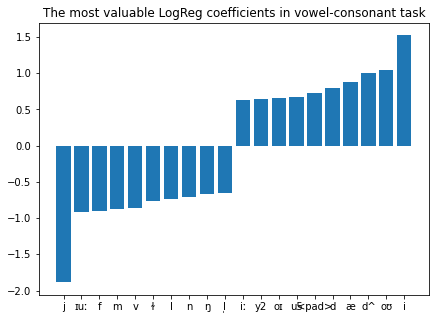

In [ ]:
df = pd.DataFrame(np.load(f'{path}25_layer.npy', allow_pickle=True))
df = df.rename(columns={0: 'sound', 1: 'vector'})

vectors = []
sounds = []

for sound in all_sounds:
  my_vectors = df[df['sound']==sound]['vector'].tolist()
  my_vectors = get_list_of_vectors(my_vectors)
  vectors.extend(my_vectors)
  sounds.extend([vowel_or_not[sound]]*len(my_vectors))

logreg = LogisticRegression(max_iter=1000)
X_train , X_test , Y_train , Y_test = train_test_split(vectors,sounds,train_size = .8)
under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(X_train, Y_train)
logreg.fit(X_res, y_res)
score = logreg.score(X_test, Y_test)

needed_coefs = draw_coefs(logreg, 'vowel-consonant')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


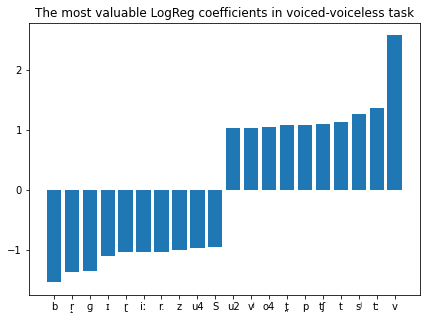

In [ ]:
vectors = []
sounds = []

for sound in consonants:
  my_vectors = df[df['sound']==sound]['vector'].tolist()
  my_vectors = get_list_of_vectors(my_vectors)
  vectors.extend(my_vectors)
  sounds.extend([voiced_or_not[sound]]*len(my_vectors))

logreg = LogisticRegression(max_iter=1000)
X_train , X_test , Y_train , Y_test = train_test_split(vectors,sounds,train_size = .8)
under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(X_train, Y_train)
logreg.fit(X_res, y_res)
score = logreg.score(X_test, Y_test)

needed_coefs = draw_coefs(logreg, 'voiced-voiceless')

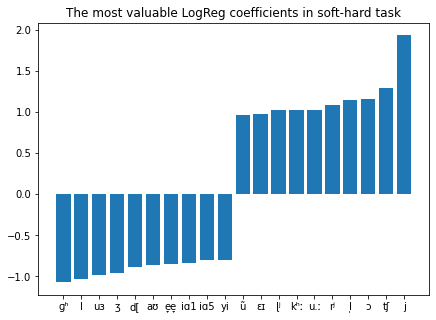

In [ ]:
vectors = []
sounds = []

for sound in soft.union(hard):
  my_vectors = df[df['sound']==sound]['vector'].tolist()
  my_vectors = get_list_of_vectors(my_vectors)
  vectors.extend(my_vectors)
  sounds.extend([soft_or_not[sound]]*len(my_vectors))

logreg = LogisticRegression(max_iter=1000)
X_train , X_test , Y_train , Y_test = train_test_split(vectors,sounds,train_size = .8)
under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(X_train, Y_train)
logreg.fit(X_res, y_res)
score = logreg.score(X_test, Y_test)

needed_coefs = draw_coefs(logreg, 'soft-hard')

In [ ]:
logreg.coefs

In [ ]:
df = pd.DataFrame(np.load(f'{path}25_layer.npy', allow_pickle=True))
df = df.rename(columns={0: 'sound', 1: 'vector'})

sounds, rand_sounds, vectors = get_vectors(df, 'soft/hard')
full_rand = [el for el in sounds]
random.shuffle(full_rand)

In [ ]:
sounds = np.array(sounds)
vectors = np.array(vectors)

#sounds = sounds.reshape((sounds.shape[0], 1))

In [ ]:
vectors.shape, sounds.shape

((22429, 392), (22429,))

##### Comparing soft and hard sounds

In [ ]:
soft_data = pd.DataFrame([sounds, vectors]).T
soft_data = soft_data.rename(columns={0:'sound', 1:'vector'})

In [ ]:
soft_means = soft_data.groupby('sound')['vector'].agg('mean').reset_index()

soft_means['vector'][0][24], soft_means['vector'][1][24]

(-0.39428765, 2.0391333)

In [ ]:
soft_data['j_number'] = soft_data['vector'].apply(lambda x: x[24])
soft_data['sound_new'] = soft_data['vector'].apply(lambda x: convenient_vocab[np.argmax(x)])

In [ ]:
hards = soft_data[soft_data['sound']=='hard']
hards = hards[hards['j_number']>=2.5]

In [ ]:
softs =  soft_data[soft_data['sound']=='soft']
#aa = softs.groupby('sound')['vector'].agg('mean')[0]
mean_soft = softs.groupby('sound')['vector'].agg('mean')[0].argsort()

In [ ]:
# features which usually have the highest value on the last layer
# in soft sounds' vectors
for i in mean_soft[-10:]:
  print(i, aa[i], convenient_vocab[i])

66 1.5389228 tʃ
96 1.6041932 rʲ
10 1.6651238 i
98 1.9630953 ɭʲ
115 1.9660605 dʲ
92 1.9690461 tʲ
24 2.0391333 j
78 2.4775188 ɲ
0 2.5225825 <pad>
86 2.5863788 nʲ


In [ ]:
# comparing soft and hard pair of sounds [n] and [nʲ]
for idx in soft_data[soft_data['sound_new']=='nʲ']['vector'][0].argsort()[-10:]:
  print(soft_data[soft_data['sound_new']=='nʲ']['vector'][0][idx], convenient_vocab[idx])

0.99026203 j
1.1464334 iː
1.3421091 m
1.5209931 i
2.5681505 mʲ
2.8765373 ŋ
4.691687 n
5.326911 <pad>
5.545455 ɲ
5.716611 nʲ


In [ ]:
for idx in soft_data[soft_data['sound_new']=='n']['vector'][4269].argsort()[-10:]:
  print(soft_data[soft_data['sound_new']=='n']['vector'][4269][idx], convenient_vocab[idx])

0.8351619 nʲ
0.884071 z
1.1786121 ə
1.2880957 ɲ
1.9544166 t
2.2924128 d
2.5996447 ŋ
2.6006477 m
4.086347 <pad>
8.339016 n


In [ ]:
all_hards = soft_data[soft_data['sound']=='hard']
all_hards = all_hards[all_hards['j_number']<2.5]
mean_hard_g = all_hards[all_hards['sound_new']=='ɡ'].groupby('sound_new')['vector'].agg('mean')[0].argsort()
for i in mean_hard_g[-10:]:
  print(convenient_vocab[i])

eː
kː
ɟ
<pad>
v
ɣ
d
b
k
ɡ


In [ ]:
for idx in hards[hards['sound_new']=='ɡ']['vector'][18464].argsort()[-10:]:
  print(hards[hards['sound_new']=='ɡ']['vector'][18464][idx], convenient_vocab[idx])

2.147355 dʒ
2.1479416 ʎ
2.263015 ɣ
2.3507702 d
2.3613493 ɲ
2.4345083 dʲ
3.2225857 ɟ
3.6043274 j
4.2618275 <pad>
5.90249 ɡ


In [ ]:
mean_g = hards[hards['sound_new']=='ɡ'].groupby('sound_new')['vector'].agg('mean')[0].argsort()
for i in mean_g[-10:]:
  print(convenient_vocab[i])

dʒ
d
ɲ
dʲ
k
ɣ
j
<pad>
ɟ
ɡ


In [ ]:
for item in box['caps']:
  print(item.get_ydata())

[-2.67005229 -2.67005229]
[1.92105412 1.92105412]


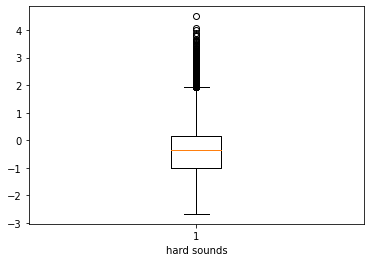

In [ ]:
# comparing value of [j] sound in vectors of hard and soft sounds
plt.boxplot(soft_data[soft_data['sound']=='hard']['j_number'])
plt.xlabel('hard sounds')
plt.savefig('j_distr.pdf')

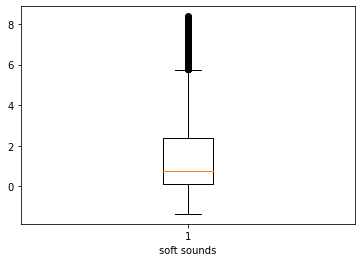

In [ ]:
plt.boxplot(soft_data[soft_data['sound']=='soft']['j_number'])
plt.xlabel('soft sounds')
plt.savefig('j_distr_soft.pdf')

##### Probing on different tests

In [ ]:
np.save(path + 'scores.npy', scores)
np.save(path + 'rand_scores.npy', rand_scores)
np.save(path + 'full_rand_scores.npy', full_rand_scores)

In [ ]:
def draw_accuracy(dict_of_scores):
  '''
  dict_of_scores: словарь, в котором ключом является тип перемешивания,
  а значением список значений accuracy
  '''
  xs = [i for i in range(1, 27)]
  for k, v in dict_of_scores.items():
    plt.plot(xs, v, label=k)
  plt.legend()
  plt.title('Accuracy предсказания звонкости звука на каждом из слоёв')
  plt.xlabel('Номер слоя')
  plt.ylabel('Значение accuracy')

In [ ]:
scores = np.load(path + 'scores.npy', allow_pickle=True)
scores = scores.tolist()
rand_scores = np.load(path + 'rand_scores.npy', allow_pickle=True)
rand_scores = rand_scores.tolist()
full_rand_scores = np.load(path + 'full_rand_scores.npy', allow_pickle=True)
full_rand_scores = full_rand_scores.tolist()

In [ ]:
scores['vowel/consonant'][-1]

0.9990897269180754

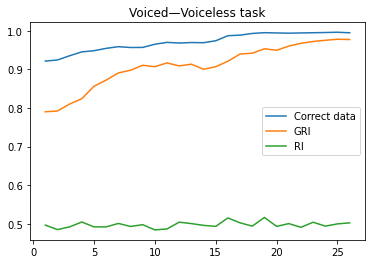

In [ ]:
xs = [i for i in range(1, 27)]
testname = 'voiced/voiceless'
plt.plot(xs, scores[testname], label='Correct data') #, label=k)
plt.plot(xs, rand_scores[testname], label='GRI') #, label=k)
plt.plot(xs, full_rand_scores[testname], label='RI') #, label=k)
plt.legend()
plt.title('Voiced—Voiceless task')
plt.savefig('voiced.pdf')

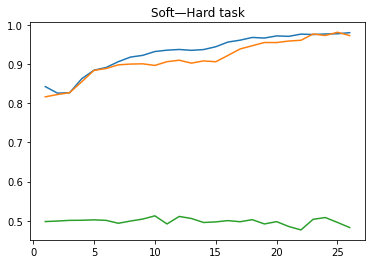

In [ ]:
xs = [i for i in range(1, 27)]
testname = 'soft/hard'
plt.plot(xs, scores[testname], label='Correct data') #, label=k)
plt.plot(xs, rand_scores[testname], label='Random Initialization') #, label=k)
plt.plot(xs, full_rand_scores[testname], label='Group Random Initialization') #, label=k)
plt.title('Soft—Hard task')
plt.savefig('soft.pdf')

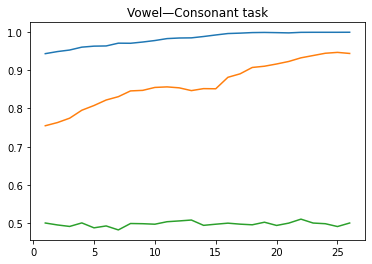

In [ ]:
xs = [i for i in range(1, 27)]
testname = 'vowel/consonant'
plt.plot(xs, scores[testname], label='Correct data') #, label=k)
plt.plot(xs, rand_scores[testname], label='Random Initialization') #, label=k)
plt.plot(xs, full_rand_scores[testname], label='Group Random Initialization') #, label=k)
plt.title('Vowel—Consonant task')
plt.savefig('vowel.pdf')

In [ ]:
[i - j for i, j in zip(scores['vowel/consonant'], rand_scores['vowel/consonant'])]

[0.18824597820446287,
 0.18539180072651784,
 0.1779968863518423,
 0.16476388168137002,
 0.1550337311883757,
 0.14115204981837048,
 0.13972496107939802,
 0.12441619097042045,
 0.1262324857291126,
 0.1224701608718215,
 0.12610275038920593,
 0.1301245459263103,
 0.13777893098079919,
 0.13609237156201348,
 0.14050337311883754,
 0.11429683445770633,
 0.10625324338349773,
 0.09107420861442661,
 0.08822003113648158,
 0.08186299948105868,
 0.0745978204462896,
 0.066554229372081,
 0.060707395498392325,
 0.0547464239271781,
 0.052475884244372994,
 0.0553966189856957]

In [ ]:
def draw_coefs(model, testname):
  '''
  model -> используемая модель LogReg
  testname -> название теста
  '''
  all_coefs = np.argsort(model.coef_[0])
  need_coefs = all_coefs[:10].tolist() + all_coefs[-10:].tolist()
  sounds = []
  coefs = []
  for coef in need_coefs:
    sounds.append(convenient_vocab[coef])
    coefs.append(model.coef_[0][coef])
  plt.figure(figsize=(7, 5))
  plt.bar(sounds, coefs)
  plt.title(f'The most valuable LogReg coefficients in {testname} task')
  plt.savefig(f'{testname}.pdf')

  return need_coefs

In [ ]:
my_dataframe = np.load(path + '25_layer.npy', allow_pickle=True)

In [ ]:
df = pd.DataFrame(my_dataframe)
df = df.rename(columns={0: 'sound', 1: 'vector'})

#sounds, rand_sounds, vectors = get_vectors(df, testname)

all_sound_vectors = defaultdict(list)
for sound in all_sounds:
  my_vectors = df[df['sound']==sound]['vector'].tolist()
  my_vectors = get_list_of_vectors(my_vectors)
  all_sound_vectors[sound].extend(my_vectors)

In [ ]:
nears = {}
for key in all_sound_vectors.keys():
  s = np.argsort(np.mean(all_sound_vectors[key], axis=0))
  nears[key] = [convenient_vocab[index] for index in s[-20:]]

In [ ]:
nears

#### Vectors' similarities

Table where lines and columns are sounds, at the intersection there is a confidence degree oth the model that shows how sounds are similar to each other

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
means = {}
keys = all_sound_vectors.keys()
for key in vocab.keys():
  if key in keys:
    values = all_sound_vectors[key]
    mean_val = np.mean(values, axis=0)
    means[key] = mean_val
  else:
   means[key] = np.zeros(392)

In [ ]:
data = means
index = list(vocab.keys())
columns = list(vocab.keys())
df = pd.DataFrame(data=means, index=index, columns=columns)

I need sounds that are seen in Wav2Vec dictionary. I divide all sounds into two tables for consonants and vowels

In [ ]:
new_df = df.T
end = new_df[new_df['<s>']!=0]

In [ ]:
vowel_cols = []
cons_cols = []
for col in end.columns:
  for sound in vowels:
    if col.startswith(sound):
      if col not in vowel_cols:
        vowel_cols.append(col)
for col in end.columns:
  if col not in vowel_cols:
    cons_cols.append(col)

In [ ]:
df_vowels = pd.DataFrame(columns = end.columns)
df_cons = pd.DataFrame(columns = end.columns)

In [ ]:
for i, row in end.iterrows():
  if i in vowel_cols:
    df_vowels.loc[i] = row
  else:
    df_cons.loc[i] = row

I delete those sounds which have low values: do not have similar sound in the dictionary

In [ ]:
del_cols_vows = []
del_cols_cons = []
for col in vowel_cols:
  if (df_vowels[col] < -1).sum() > (df_vowels[col] > -1).sum():
    del_cols_vows.append(col)
for col in cons_cols:
  if (df_cons[col] < 0).sum() > (df_cons[col] > -1.5).sum():
    del_cols_cons.append(col)
del_cols_cons.append('<s>')

In [ ]:
needed_cols_vows = []
needed_cols_cons = []
for col in vowel_cols:
  if col not in del_cols_vows:
    needed_cols_vows.append(col)
for col in cons_cols:
  if col not in del_cols_cons:
    needed_cols_cons.append(col)

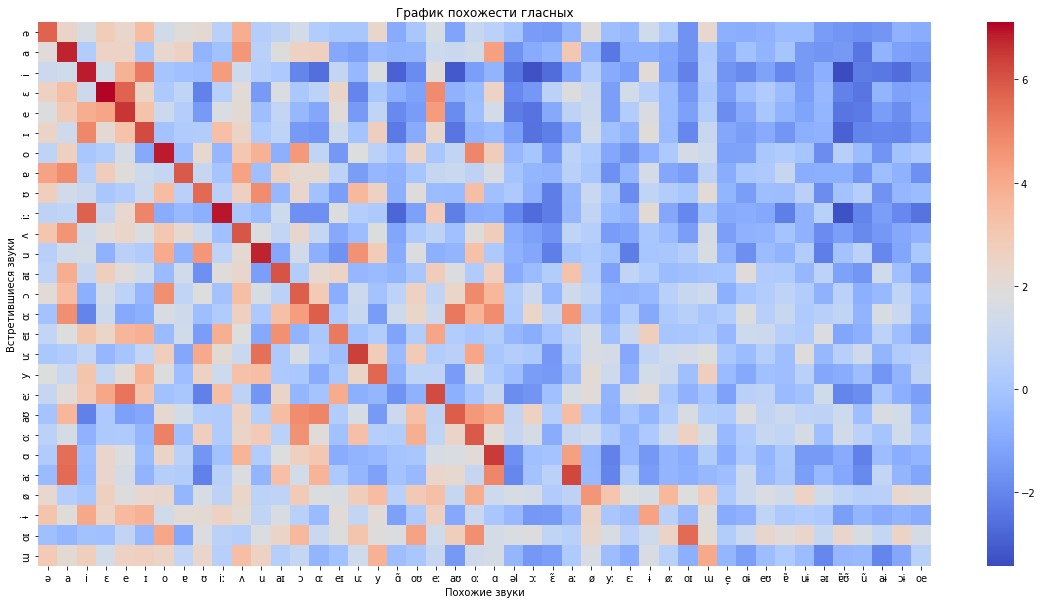

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(df_vowels[needed_cols_vows], cmap='coolwarm')
plt.xlabel('Похожие звуки')
plt.ylabel('Встретившиеся звуки')
plt.title('График похожести гласных')
plt.savefig(fname='vowel_heatmap.pdf', format='pdf')

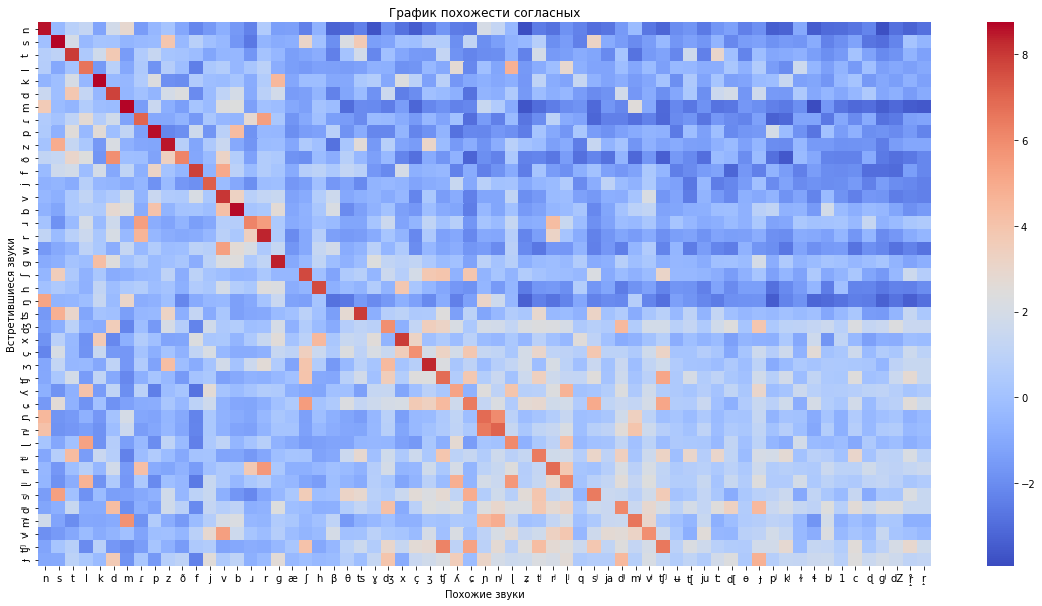

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(df_cons[needed_cols_cons], cmap='coolwarm')
plt.xlabel('Похожие звуки')
plt.ylabel('Встретившиеся звуки')
plt.title('График похожести согласных')
plt.savefig(fname='consonant_heatmap.pdf', format='pdf')

In [ ]:
for k, v in nears.items():
  print(k)
  print(*v[-1::-1])

oɪ
oɪ oː oʊ o ɔ uː aʊ ɵ øː ʉ ɔɨ aɪ ɔø ɐ̃ʊ̃ ø eʊ uɨ ɔ̃ œ ɯ
ɛ
ɛ e eː æ a ə ɑ ɪ eɪ ʌ <pad> aː aɪ ɛː i ø œ ja ɐ ɾ
ɑ
ɑ a aː ʌ ɑː ɔ o ɛ oː æ <pad> aɪ e aʊ eː v h ɐ r ɵ
k
k ɡ <pad> x p t kː kʲ q tʲ ç tʃ ɣ ʌ kh r a ɾ f i
ɪ
ɪ i iː e <pad> y ʌ ə eː ɛ ɨ ø a j eɪ ᵻ ja ɯ ʉ aɪ
ɭ
ɭ l ɭʲ ʎ <pad> ɫ l̩ dʲ d[ z v rʲ ɟ vʲ ʌ r d o y oː
e
e eː ɛ i ɪ a <pad> ʌ eɪ ə iː ɨ æ ɑ ja ø o j aɪ y
ɹ
ɹ r ɾ rʲ <pad> l d dʒ ɚ ɭʲ ɖ ɭ ʒ ʎ v yː ʁ b ø ɜ
ɨ
ɨ i ɪ e ə eː iː ɛ ø <pad> ʉ ʊ ʌ ɐ y eɪ a ɯ aɪ o
tʃʲ
tʃʲ tʃ ɕ tʲ ʃ sʲ dʒ r̝̊ ʒ kʲ nʲ rʲ S tS ç c ʑ ɭʲ tɕh dʲ
d
d t ð <pad> b d[ z dʲ ɡ ɟ dʒ tː n l v r ɭ ɖ ɫ t[
ɯ
ɯ y ʌ ə ʉ i ɪ <pad> u e o ʊ a ø ɨ ɑ ɛ uː oː ɵ
f
f v <pad> p x k t s θ m h b ts ʃ ʌ r β vʲ u ɡ
ŋ
ŋ n <pad> ɲ m nʲ ɡ k iː mʲ i ə u ɪ h r eɪ z uː ʌ
mʲ
mʲ m nʲ ɲ vʲ b v ɭʲ bʲ n y ŋ dʲ ja ju i ɭ rʲ eɪ <pad>
a
a ʌ ɑ aː ɑː ɐ ɔ ɛ e o <pad> æ ə aɪ oː eː aʊ u v ɜ
ʃ
ʃ tʃ ɕ ʒ s tʃʲ sʲ <pad> S s. ç r̝̊ dʒ z f ʂ ts x r̝ ʑ
s
s z ts sʲ ʃ <pad> θ t ɕ e s^ f ʂ tʲ ʒ tʃ i a s̪ k
ɔ
ɔ oː o ɑ a ʌ ɑː oʊ aʊ ə ʊ u <pad> ɛ aː ɯ ɵ ɔː uː ɜ
ɑː
ɑ